In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import rubin_sim.maf as maf
import rubin_scheduler.utils as rsUtils
import rubin_sim.data as data

# Set RUBIN_SIM_DATA_DIR environment variable
os.environ['RUBIN_SIM_DATA_DIR'] = '/data/a.saricaoglu/repo/RubinsForge/rubin_sim_data'

print(f"Current working directory: {os.getcwd()}")
print(f"RUBIN_SIM_DATA_DIR set to: {os.environ.get('RUBIN_SIM_DATA_DIR')}")

Current working directory: /data/a.saricaoglu/repo/RubinsForge/OpSim/scripts
RUBIN_SIM_DATA_DIR set to: /data/a.saricaoglu/repo/RubinsForge/rubin_sim_data


In [2]:
baseline_file = data.get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)

WE need to get coordinates for desired targets from the csv file. (Will be removed and put in utils script later on)

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord

# Read the CSV file and examine its structure
df = pd.read_csv('/data/a.saricaoglu/repo/RubinsForge/LenSim/output.csv')

print("CSV file structure:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nData types:")
print(df.dtypes)

# Create targets dictionary with all requested fields
targets = {}

for index, row in df.iterrows():
    # Create SkyCoord object for each target
    coord = SkyCoord(ra=row['ra'] * u.degree, dec=row['dec'] * u.degree, frame='icrs')
    
    # Create target ID (you can modify this naming scheme)
    target_id = f"target_{index:04d}"
    
    # Build the target dictionary with all requested fields
    targets[target_id] = {
        'ra': row['ra'],  # degrees
        'dec': row['dec'],  # degrees
        'coord': coord,  # SkyCoord object for convenience
        
        # Initialize other fields - update these based on your CSV columns
        'name': row.get('name',None),  # Use CSV value if exists, else default name
        'flag': row.get('flag', None),
        'n_img': row.get('n_img', None),  # Use CSV value if exists, else None
        'image_conf': row.get('image_conf', None),
        'lens_type': row.get('lens_type', None),
        'source_type': row.get('source_type', None),
        'mag': row.get('mag', None),
        'Dmag': row.get('Dmag', None), 
        'value': row.get('value', None),
        'dvalue_min': row.get('dvalue_min', None),
        'dvalue_max': row.get('dvalue_max', None),
        
    }

print(f"\nCreated targets dictionary with {len(targets)} targets")
print(f"Target IDs: {list(targets.keys())[:5]}...")  # Show first 5 IDs

# Show structure of first target
first_target_id = list(targets.keys())[0]
print(f"\nStructure of {first_target_id}:")
for key, value in targets[first_target_id].items():
    if key != 'coord':  # Skip coord object for cleaner display
        print(f"  {key}: {value}")

# Also create a SkyCoord array for convenience (as in original code)
coordinates = SkyCoord([targets[tid]['coord'] for tid in targets.keys()])

CSV file structure:
Shape: (17842, 13)
Columns: ['ra', 'dec', 'name', 'alt_name', 'flag', 'score', 'image_sep', 'info', 'n_img', 'image_conf', 'lens_type', 'source_type', 'contaminant_type']

First few rows:
          ra      dec            name  \
0  149.84070  2.11067  J095921+020638   
1  149.85618  2.11212  J095925+020643   
2  149.87958  2.04139  J095931+020229   
3  149.89480  2.10936  J095934+020633   
4  149.99875  2.06333  J095959+020347   

                                            alt_name       flag  score  \
0  095921+020638, J095921+020638, J09h59m21.768s ...  CONFIRMED    NaN   
1                                                NaN  CANDIDATE    2.0   
2                                                NaN  CANDIDATE    2.0   
3                                                NaN  CANDIDATE    2.0   
4                                                NaN  CANDIDATE    2.0   

   image_sep info  n_img image_conf   lens_type           source_type  \
0       1.38  NaN    NaN   

In [4]:
# Helper functions to work with targets dictionary

def get_target_coordinates(targets_dict):
    """Extract RA and Dec arrays from targets dictionary"""
    ra_list = [targets_dict[tid]['ra'] for tid in targets_dict.keys()]
    dec_list = [targets_dict[tid]['dec'] for tid in targets_dict.keys()]
    return np.array(ra_list), np.array(dec_list)

def get_targets_by_criteria(targets_dict, **criteria):
    """Filter targets based on criteria
    Example: get_targets_by_criteria(targets, lens_type='SIE', mag='>20')
    """
    filtered_targets = {}
    
    for tid, target_data in targets_dict.items():
        include_target = True
        
        for field, condition in criteria.items():
            if field not in target_data:
                include_target = False
                break
                
            value = target_data[field]
            
            # Handle different condition types
            if isinstance(condition, str) and condition.startswith('>'):
                threshold = float(condition[1:])
                if value is None or value <= threshold:
                    include_target = False
                    break
            elif isinstance(condition, str) and condition.startswith('<'):
                threshold = float(condition[1:])
                if value is None or value >= threshold:
                    include_target = False
                    break
            else:
                # Exact match
                if value != condition:
                    include_target = False
                    break
        
        if include_target:
            filtered_targets[tid] = target_data
    
    return filtered_targets

def update_target_field(targets_dict, target_id, field, value):
    """Update a specific field for a target"""
    if target_id in targets_dict:
        targets_dict[target_id][field] = value
        print(f"Updated {target_id}: {field} = {value}")
    else:
        print(f"Target {target_id} not found")

def print_target_summary(targets_dict, max_targets=10):
    """Print a summary of targets"""
    print(f"TARGETS SUMMARY ({len(targets_dict)} total targets)")
    print("=" * 60)
    
    # Show first few targets
    for i, (tid, target_data) in enumerate(targets_dict.items()):
        if i >= max_targets:
            print(f"... and {len(targets_dict) - max_targets} more targets")
            break
            
        print(f"{tid}:")
        print(f"  RA: {target_data['ra']:.4f}°, Dec: {target_data['dec']:.4f}°")
        
        # Show non-None fields
        other_fields = {k: v for k, v in target_data.items() 
                       if k not in ['ra', 'dec', 'coord'] and v is not None}
        if other_fields:
            for field, value in other_fields.items():
                print(f"  {field}: {value}")
        print()

# Demonstrate usage
print("TARGETS DICTIONARY USAGE EXAMPLES:")
print("=" * 50)

# Get coordinate arrays for MAF analysis
ra_array, dec_array = get_target_coordinates(targets)
print(f"Extracted coordinates: {len(ra_array)} RA values, {len(dec_array)} Dec values")

# Print summary
print_target_summary(targets, max_targets=3)

# Example: Update some fields (you can modify these based on your actual data)
first_target = list(targets.keys())[0]
update_target_field(targets, first_target, 'n_img', 4)
update_target_field(targets, first_target, 'lens_type', 'SIE+SHEAR')
update_target_field(targets, first_target, 'mag', 19.5)

print(f"\nUpdated target {first_target}:")
for key, value in targets[first_target].items():
    if key != 'coord' and value is not None:
        print(f"  {key}: {value}")

TARGETS DICTIONARY USAGE EXAMPLES:
Extracted coordinates: 17842 RA values, 17842 Dec values
TARGETS SUMMARY (17842 total targets)
target_0000:
  RA: 149.8407°, Dec: 2.1107°
  name: J095921+020638
  flag: CONFIRMED
  n_img: nan
  image_conf: []
  lens_type: ['GALAXY']
  source_type: ['GALAXY', 'QUASAR']

target_0001:
  RA: 149.8562°, Dec: 2.1121°
  name: J095925+020643
  flag: CANDIDATE
  n_img: nan
  image_conf: []
  lens_type: ['GALAXY']
  source_type: []

target_0002:
  RA: 149.8796°, Dec: 2.0414°
  name: J095931+020229
  flag: CANDIDATE
  n_img: nan
  image_conf: []
  lens_type: ['GALAXY']
  source_type: []

... and 17839 more targets
Updated target_0000: n_img = 4
Updated target_0000: lens_type = SIE+SHEAR
Updated target_0000: mag = 19.5

Updated target target_0000:
  ra: 149.8407
  dec: 2.11067
  name: J095921+020638
  flag: CONFIRMED
  n_img: 4
  image_conf: []
  lens_type: SIE+SHEAR
  source_type: ['GALAXY', 'QUASAR']
  mag: 19.5


In [5]:
bundle_list = []

# Get coordinates from targets dictionary
ra, dec = get_target_coordinates(targets)

print(f"Setting up MAF analysis for {len(targets)} targets")
print(f"RA range: {ra.min():.3f}° to {ra.max():.3f}°")
print(f"Dec range: {dec.min():.3f}° to {dec.max():.3f}°")

# Say we just want to pass data through, not compute anything. Documentation on 
# columns at:  https://rubin-sim.lsst.io/rs_scheduler/output_schema.html
metric = maf.metrics.PassMetric(cols=['observationID','fieldRA','fieldDec', 'filter', 'observationStartMJD', 'fiveSigmaDepth', 'visitExposureTime', 'numExposures', 'seeingFwhm500',
'seeingFwhmEff', 'skyBrightness'])

# Select all the visits. Could be something like "filter='r'", "night < 365", etc
sql = ''
slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name))

print(f"Created MetricBundle for {len(ra)} target positions")

Setting up MAF analysis for 17842 targets
RA range: 0.025° to 359.993°
Dec range: -85.747° to 88.706°
Created MetricBundle for 17842 target positions


In [6]:
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()

In [7]:
# Our bundleList now has values. The trailing [0] is to get the first result. If we specified more
# ra,dec point, those results would be in the later indices.
bundle_list[0].metric_values[0][0:10]

rec.array([(151.31806365, 1.16681665, 23.56016746, 1.24924411, 63265.28621649, 20.08564546, 29.2, 0.8420811 , 153.50919201, 'r', 2, 1242331),
           (151.33133367, 0.89485862, 21.82282763, 1.01669317, 61897.13045355, 17.80327714, 29.2, 0.43827107,  98.61920309, 'y', 2,  522825),
           (151.31806365, 0.90937276, 23.61387153, 1.24924411, 63265.26193135, 19.78227196, 29.2, 0.65308275, 153.50919201, 'i', 2, 1242280),
           (151.17041979, 1.26935544, 24.09758374, 1.25809453, 63628.10850506, 21.80616278, 29.2, 0.60102022, 116.63961706, 'g', 2, 1451896),
           (150.86018963, 1.0513173 , 23.04469937, 1.01702388, 63635.20148852, 19.30648317, 29.2, 0.82231424,  47.33928445, 'z', 2, 1456840),
           (151.16612267, 0.78762708, 22.37236918, 1.17076234, 61450.18987927, 18.43874529, 29.2, 0.55661768, 130.90804071, 'y', 2,  245684),
           (150.94630163, 1.0640197 , 24.19233807, 0.85294683, 61081.24017739, 21.19475131, 29.2, 0.70962276,  51.74588317, 'g', 2,   43532),
      

Observation period: MJD 61000 to 64483


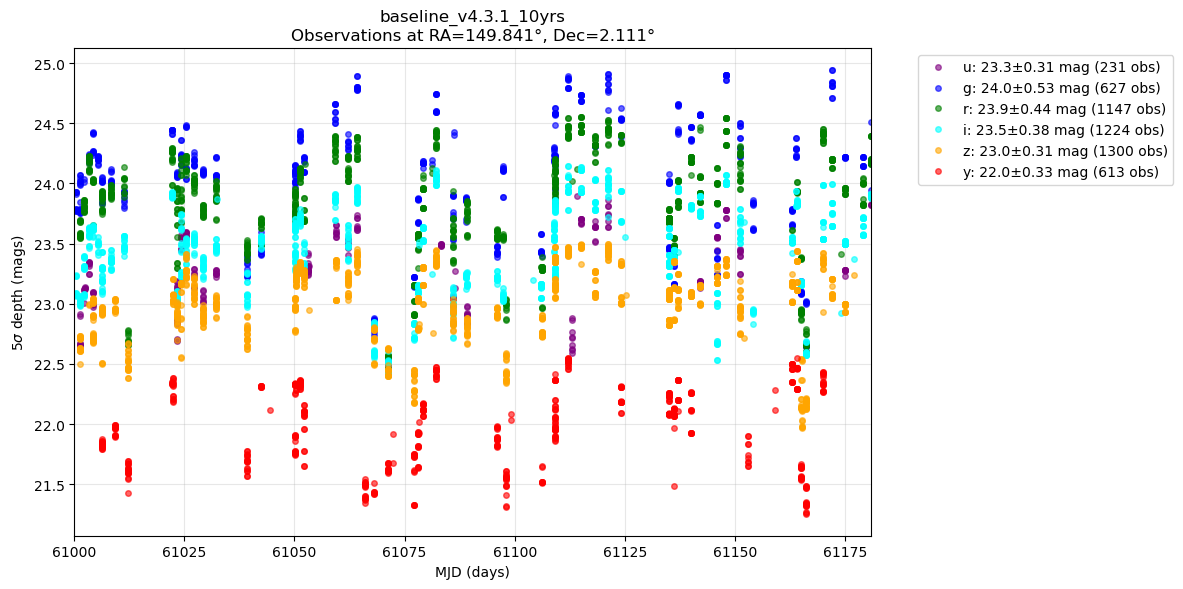


OBSERVATION SUMMARY for RA=149.841°, Dec=2.111°
Total observations: 42447
Time range: 61000 - 61181 MJD
Observations in time range: 5142

FILTER PERFORMANCE:
Filter   Mean Depth   Std      Range           N_obs   
-------------------------------------------------------
g        24.05        0.525    22.5-24.9       627     
i        23.46        0.381    22.4-24.1       1224    
r        23.86        0.443    22.4-24.6       1147    
u        23.30        0.310    22.6-23.9       231     
y        21.99        0.333    21.3-22.5       613     
z        23.00        0.313    22.0-23.5       1300    

DEEPEST FILTER: g (mean depth: 24.05 mag)
SHALLOWEST FILTER: y (mean depth: 21.99 mag)
DEPTH RANGE: 2.05 magnitudes between deepest and shallowest filters


In [8]:
# As a bit of foreshadowing for how the rest of MAF works, we'll call the visits overlapping a
# single point in the sky "dataSlice". 
data_slice_total = bundle_list[0].metric_values[0]
print(f"Observation period: MJD {np.min(data_slice_total['observationStartMJD']):.0f} to {np.max(data_slice_total['observationStartMJD']):.0f}")

# Observation period start and end
start = 61000 # MJD, 2025-11-21
end = 61181   # MJD, 2026-05-21
# Update data_slice to only include observations within the specified time range
data_slice = data_slice_total[(data_slice_total['observationStartMJD'] >= start) & (data_slice_total['observationStartMJD'] <= end)]

# Let's plot up what the 5-sigma depth looks like
plt.figure(figsize=(12, 6))

# Give each filter it's own color
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}

# Track statistics for each filter
filter_stats = {}

for fn in f2c:
    in_filt = np.where(data_slice['filter'] == fn)[0]
    if len(in_filt) > 0:  # Only plot if we have data
        depths = data_slice['fiveSigmaDepth'][in_filt]
        mjds = data_slice['observationStartMJD'][in_filt]
        
        plt.plot(mjds, depths, 'o',
                 color=f2c[fn],
                 label=f'{fn}: {np.mean(depths):.1f}±{np.std(depths):.2f} mag ({len(in_filt)} obs)',
                 alpha=0.6, markersize=4)
        
        # Store statistics
        filter_stats[fn] = {
            'mean_depth': np.mean(depths),
            'std_depth': np.std(depths),
            'min_depth': np.min(depths),
            'max_depth': np.max(depths),
            'n_obs': len(in_filt)
        }

plt.xlim(start, end)
plt.xlabel('MJD (days)')
plt.ylabel(r'5$\sigma$ depth (mags)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f'{name}\nObservations at RA={ra[0]:.3f}°, Dec={dec[0]:.3f}°')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed statistics
print(f'\n{"="*60}')
print(f'OBSERVATION SUMMARY for RA={ra[0]:.3f}°, Dec={dec[0]:.3f}°')
print(f'{"="*60}')
print(f'Total observations: {len(data_slice_total)}')
print(f'Time range: {start} - {end} MJD')
time_filtered = data_slice_total[(data_slice_total["observationStartMJD"] >= start) & (data_slice_total["observationStartMJD"] <= end)]
print(f'Observations in time range: {len(time_filtered)}')

print(f'\nFILTER PERFORMANCE:')
print(f'{"Filter":<8} {"Mean Depth":<12} {"Std":<8} {"Range":<15} {"N_obs":<8}')
print(f'{"-"*55}')
for fn in sorted(filter_stats.keys()):
    stats = filter_stats[fn]
    range_str = f"{stats['min_depth']:.1f}-{stats['max_depth']:.1f}"
    print(f'{fn:<8} {stats["mean_depth"]:<12.2f} {stats["std_depth"]:<8.3f} {range_str:<15} {stats["n_obs"]:<8}')

# Find deepest and shallowest filters
if filter_stats:
    deepest_filter = max(filter_stats.keys(), key=lambda x: filter_stats[x]['mean_depth'])
    shallowest_filter = min(filter_stats.keys(), key=lambda x: filter_stats[x]['mean_depth'])
    
    print(f'\nDEEPEST FILTER: {deepest_filter} (mean depth: {filter_stats[deepest_filter]["mean_depth"]:.2f} mag)')
    print(f'SHALLOWEST FILTER: {shallowest_filter} (mean depth: {filter_stats[shallowest_filter]["mean_depth"]:.2f} mag)')
    
    depth_range = filter_stats[deepest_filter]['mean_depth'] - filter_stats[shallowest_filter]['mean_depth']
    print(f'DEPTH RANGE: {depth_range:.2f} magnitudes between deepest and shallowest filters')

### Practical Example: What Can We Detect?

The 5-sigma depth tells us the **faintest magnitude** we can reliably detect. Here's what different depths mean:

#### Typical LSST 5σ Depths:
- **u-band**: ~23.5 mag (shallowest due to atmosphere)
- **g-band**: ~24.5 mag 
- **r-band**: ~24.0 mag
- **i-band**: ~23.5 mag
- **z-band**: ~22.5 mag
- **y-band**: ~21.5 mag (shallowest due to sky brightness)

#### Real Objects at These Depths:
- **Magnitude 20**: Bright quasars, nearby supernovae
- **Magnitude 22**: Distant galaxies, faint asteroids
- **Magnitude 24**: Very distant galaxies, faint stars in nearby galaxies
- **Magnitude 26**: Galaxy at redshift z~3-4, brown dwarfs

#### Why the Scatter in Your Plot?
1. **Atmospheric seeing**: Better seeing = deeper observations
2. **Sky brightness**: Moon phase and elevation affect background
3. **Airmass**: Objects near horizon are harder to observe
4. **Weather**: Clouds and humidity reduce sensitivity

**Higher 5σ depth = Better observation = Can detect fainter objects!**

## Understanding 5-Sigma Depth

**5-sigma depth** is a key observational metric that tells us **how faint an object we can detect** with high confidence in each observation.

### What it means:
- **5-sigma**: Statistical significance level - we're 99.99994% confident the detection is real (not noise)
- **Depth**: The faintest magnitude we can reliably detect
- **Higher magnitude = fainter object** (astronomical magnitude scale is backwards!)

### Key Points:
- **Deeper observations** (higher 5σ depth values) can detect fainter objects
- **Different filters** have different sensitivities based on:
  - Atmospheric transmission
  - CCD quantum efficiency  
  - Sky brightness in that band
  - Exposure time and seeing conditions

### In LSST Context:
- **u-band**: Typically shallowest due to atmospheric absorption
- **i,z,y-bands**: Often deepest due to good atmospheric transmission and detector response
- **Seeing conditions** and **sky brightness** vary nightly, causing scatter in the plot

In [ ]:
# Now, let's check how seeing changes for different observations of the same target




<function print(*args, sep=' ', end='\n', file=None, flush=False)>